In [1]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree

print("✅ Libraries successfully imported")

✅ Libraries successfully imported


###  <u> **2 -  Model 2 / Model including  the weather conditions** <u>

#### a) Import the dataset of the weather condition 

We found the weather dataset on the following link: https://meteo.data.gouv.fr/datasets/6569b51ae64326786e4e8e1a

In [2]:
BASE_PATH = r"data/"  # Base du répertoire
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous_1950-2023_RR-T-Vent.csv"

def read_meteo_data(path=METEO_PATH, sep=";", enc="utf-8", parse_dates=True):
    """
    Lit le fichier météo et renvoie un DataFrame Pandas.
    
    Paramètres
    ----------
    path : str
        Chemin du fichier météo.
    sep : str
        Séparateur utilisé dans le CSV.
    enc : str
        Encodage du fichier.
    parse_dates : bool
        Si vrai, convertit automatiquement les colonnes de dates.
    """
    
    print(f"Lecture du fichier météo : {path}")
    
    df = pd.read_csv(path, sep=sep, encoding=enc)
    
    # Si parse_dates = True → on détecte automatiquement les colonnes de dates
    if parse_dates:
        # Essaie de convertir toute colonne contenant 'date' ou 'Date'
        date_cols = [col for col in df.columns if "date" in col.lower()]
        for col in date_cols:
            df[col] = pd.to_datetime(df[col], errors="coerce")
    
    return df


In [3]:
BASE_PATH = r"data/"  #replace with base path to meteo's data
METEO_PATH = BASE_PATH + r"data-meteo/Q_69_previous_1950-2023_RR-T-Vent.csv"

df_meteo = read_meteo_data(METEO_PATH)
df_meteo



Lecture du fichier météo : data/data-meteo/Q_69_previous_1950-2023_RR-T-Vent.csv


,NUM_POSTE,NOM_USUEL,LAT,LON,ALTI,AAAAMMJJ,RR,QRR,TN,QTN,...,HXI2,QHXI2,FXI3S,QFXI3S,DXI3S,QDXI3S,HXI3S,QHXI3S,DRR,QDRR
0,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630301,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630302,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630303,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630304,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,69006001,AMPLEPUIS BOURG,45.971667,4.331667,435,19630305,0.0,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1245503,69299001,LYON-ST EXUPERY,45.726500,5.077833,235,20231227,0.0,1.0,-2.4,1.0,...,NaN,NaN,19.0,1.0,NaN,NaN,1650.0,9.0,0.0,9.0
1245504,69299001,LYON-ST EXUPERY,45.726500,5.077833,235,20231228,0.2,1.0,8.4,1.0,...,NaN,NaN,17.7,1.0,NaN,NaN,1733.0,9.0,120.0,9.0
1245505,69299001,LYON-ST EXUPERY,45.726500,5.077833,235,20231229,0.2,1.0,9.2,1.0,...,NaN,NaN,14.5,1.0,NaN,NaN,121.0,9.0,35.0,9.0
1245506,69299001,LYON-ST EXUPERY,45.726500,5.077833,235,20231230,0.0,1.0,4.2,1.0,...,NaN,NaN,13.6,1.0,NaN,NaN,2353.0,9.0,0.0,9.0


### b) Analyse of the dataset weather, df_meteo

In [4]:
df_meteo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1245508 entries, 0 to 1245507
Data columns (total 58 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   NUM_POSTE  1245508 non-null  int64  
 1   NOM_USUEL  1245508 non-null  object 
 2   LAT        1245508 non-null  float64
 3   LON        1245508 non-null  float64
 4   ALTI       1245508 non-null  int64  
 5   AAAAMMJJ   1245508 non-null  int64  
 6   RR         1242894 non-null  float64
 7   QRR        1243398 non-null  float64
 8   TN         604408 non-null   float64
 9   QTN        604559 non-null   float64
 10  HTN        143111 non-null   float64
 11  QHTN       143460 non-null   float64
 12  TX         605460 non-null   float64
 13  QTX        605559 non-null   float64
 14  HTX        143174 non-null   float64
 15  QHTX       143541 non-null   float64
 16  TM         171496 non-null   float64
 17  QTM        171512 non-null   float64
 18  TNTXM      603928 non-null   float64
 19  

In [5]:
df_meteo.columns

Index(['NUM_POSTE', 'NOM_USUEL', 'LAT', 'LON', 'ALTI', 'AAAAMMJJ', 'RR', 'QRR',
       'TN', 'QTN', 'HTN', 'QHTN', 'TX', 'QTX', 'HTX', 'QHTX', 'TM', 'QTM',
       'TNTXM', 'QTNTXM', 'TAMPLI', 'QTAMPLI', 'TNSOL', 'QTNSOL', 'TN50',
       'QTN50', 'DG', 'QDG', 'FFM', 'QFFM', 'FF2M', 'QFF2M', 'FXY', 'QFXY',
       'DXY', 'QDXY', 'HXY', 'QHXY', 'FXI', 'QFXI', 'DXI', 'QDXI', 'HXI',
       'QHXI', 'FXI2', 'QFXI2', 'DXI2', 'QDXI2', 'HXI2', 'QHXI2', 'FXI3S',
       'QFXI3S', 'DXI3S', 'QDXI3S', 'HXI3S', 'QHXI3S', 'DRR', 'QDRR'],
      dtype='object')

In this dataset, we have acces to several informations related to the weather conditions. In our model, we will focus on the effect of the wind, the temperature and precipitation. According to the "weather code", the columns below are: 
- RR : precipitation (mm) 
- TN,TX ,TM  : minimal temperature, maximum temperature, mean temparture 
- FF : wind 

### c) Filtering 

#### i) Filter on time 

We will merge the weather dataset with the  velo-lyon dataset. We have to work on the same period, so we clean our weather dataset. The period selected is between the 01/01/2019 and the 22/04/2021

In [6]:
# Date conversion
df_meteo['date'] = pd.to_datetime(df_meteo['AAAAMMJJ'].astype(str), format='%Y%m%d')

# Filter data between 2019-01-01 and 2021-04-22
start_date = pd.to_datetime("2019-01-01")
end_date = pd.to_datetime("2021-04-22")

df_meteo = df_meteo[(df_meteo['date'] >= start_date) & (df_meteo['date'] <= end_date)]


We create a column datetime_time, so after we can merge the weather dataset to our bike's dataset. 

In [7]:
#Convert AAAAMMJJ to datetime
df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date

# Verify the conversion
print(df_meteo[["AAAAMMJJ", "datetime_day"]].head())


       AAAAMMJJ datetime_day
23102  20190101   2019-01-01
23103  20190102   2019-01-02
23104  20190103   2019-01-03
23105  20190104   2019-01-04
23106  20190105   2019-01-05


C:\Users\anael\AppData\Local\Temp\ipykernel_32356\2564400722.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo["AAAAMMJJ"] = df_meteo["AAAAMMJJ"].astype(int).astype(str)
C:\Users\anael\AppData\Local\Temp\ipykernel_32356\2564400722.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meteo["datetime_day"] = pd.to_datetime(df_meteo["AAAAMMJJ"], format="%Y%m%d").dt.date


#### ii) Choice of the station 

Then, we select one station in the departement. 

In [8]:
df_meteo['NOM_USUEL'].unique()


array(['AMPUIS', 'ANCY_SAPC', 'LE BREUIL', 'BRINDAS', 'LYON-BRON',
       'CALUIRE4', 'CERCIE EN BEAUJOLAIS', 'CONDRIEU',
       'COURS LA VILLE_SAPC', 'LES HAIES', 'JULLIE', 'LAMURE-SUR-AZER',
       'LANCIE', 'LIERGUES_SAPC', "LYON TETE D'OR", 'LYON-FOURVIERE',
       'MONSOLS', 'MONTROTTIER', 'MORNANT', 'POMMIERS', 'PONT TRAMBOUZE',
       'AZOLETTE', 'LES SAUVAGES', 'ST-CYR-CHATOUX', 'ST-DIDIER-RIVER',
       'ST-DIDIER-BEAUJ', "ST-GENIS-L'ARGENTIERE", 'ST-GENIS-LAVAL',
       'ST-GEORGES-REN', 'ST-GERMAIN-L AR', 'POPEY', 'ST-SYMPHORIEN-C',
       'SAINT-VERAND', 'TRADES', 'VAUX-EN-BEAUJOL', 'VAUXRENARD',
       'VILLEFRANCHE', 'CORBAS', 'RILLIEUX', 'LYON-ST EXUPERY'],
      dtype=object)

Display the meteo stations


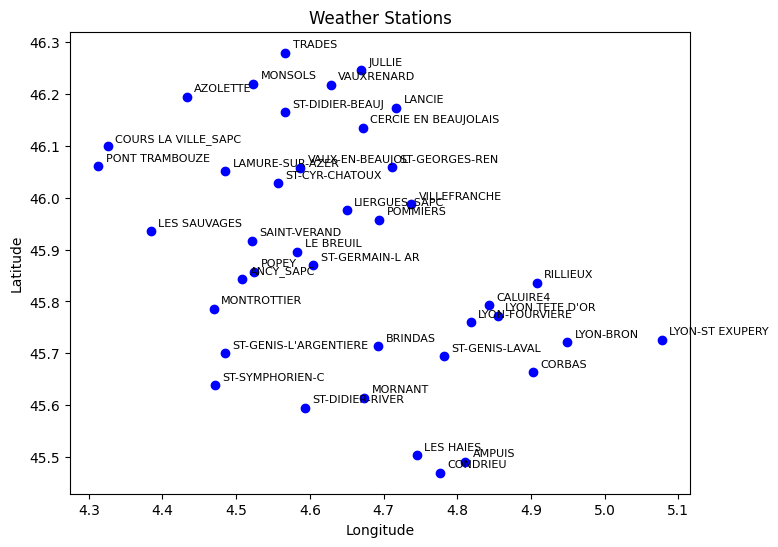

In [9]:
import matplotlib.pyplot as plt

# Supprimer les doublons pour ne garder qu'une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

plt.figure(figsize=(8,6))
plt.scatter(stations['LON'], stations['LAT'], color='blue')

# Ajouter les noms des stations
for i, row in stations.iterrows():
    plt.text(row['LON'] + 0.01, row['LAT'] + 0.01, row['NOM_USUEL'], fontsize=8)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Weather Stations")
plt.show()



We select the closest station from the center of Lyon. 

In [10]:
import pandas as pd
import numpy as np

# Exemple : coordonnées du centre de Lyon
lyon_center = (45.75, 4.85)

# Supprimer doublons pour garder une ligne par station
stations = df_meteo[['NOM_USUEL','LAT','LON']].drop_duplicates()

# Fonction Haversine
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # rayon Terre en km
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return R * c

# Calculer la distance de chaque station au centre de Lyon
stations['distance_lyon_km'] = stations.apply(
    lambda row: haversine(row['LAT'], row['LON'], lyon_center[0], lyon_center[1]),
    axis=1
)

# Trier par distance
stations = stations.sort_values('distance_lyon_km')

# Afficher les 5 stations les plus proches
print(stations[['NOM_USUEL','LAT','LON','distance_lyon_km']].head())


             NOM_USUEL        LAT       LON  distance_lyon_km
470489  LYON TETE D'OR  45.772833  4.855167          2.570359
507643  LYON-FOURVIERE  45.759667  4.818167          2.693517
179616        CALUIRE4  45.792833  4.843500          4.789420
817072  ST-GENIS-LAVAL  45.694667  4.782333          8.090095
109675       LYON-BRON  45.721333  4.949167          8.330414


We keep the station that measures the wind values, the temperature and the precipitation. 

In [11]:
# Liste des colonnes vent
vent_cols = ['FFM','FF2M','FXI','FXI2','FXI3S',"RR"]

# Vérifier par station
vent_dispo = df_meteo.groupby('NOM_USUEL')[vent_cols].apply(lambda x: x.notna().sum())

# Afficher les stations et le nombre de valeurs disponibles
print(vent_dispo.sort_values(by='FFM', ascending=False))


                       FFM  FF2M  FXI  FXI2  FXI3S   RR
NOM_USUEL                                              
ST-GEORGES-REN         843     0  843     0    516  843
LYON-ST EXUPERY        843     0  842     0    724  843
LYON-BRON              842     0  841     0    836  843
VAUXRENARD             838     0  838     0    486  843
LES SAUVAGES           818     0  821     0    490  843
BRINDAS                817     0  818     0    492  843
ANCY_SAPC                0     0    0     0      0  843
AMPUIS                   0     0    0     0      0  700
CORBAS                   0     0    0     0      0  365
CONDRIEU                 0     0    0     0      0  731
CERCIE EN BEAUJOLAIS     0     0    0     0      0  731
CALUIRE4                 0     0    0     0      0  700
AZOLETTE                 0     0    0     0      0  304
LE BREUIL                0     0    0     0      0  843
LANCIE                   0     0    0     0      0  700
COURS LA VILLE_SAPC      0     0    0     0     

We keep the meteo information of the station Lyon - Bron because it is the closest station from the center of Lyon that measures, the temperature the wind and the precipitation. 

#### iii) Filter on the Lyon - Bron station 

In [12]:
# Filter on the station "LYON-BRON"
meteo_bron = df_meteo[df_meteo['NOM_USUEL'] == "LYON-BRON"].copy()

# Verify the result 
print(meteo_bron[['NOM_USUEL', 'LAT', 'LON']].drop_duplicates())
print(meteo_bron.head())


        NOM_USUEL        LAT       LON
109675  LYON-BRON  45.721333  4.949167
        NUM_POSTE  NOM_USUEL        LAT       LON  ALTI  AAAAMMJJ   RR  QRR  \
109675   69029001  LYON-BRON  45.721333  4.949167   202  20190101  0.0  1.0   
109676   69029001  LYON-BRON  45.721333  4.949167   202  20190102  0.0  1.0   
109677   69029001  LYON-BRON  45.721333  4.949167   202  20190103  0.0  1.0   
109678   69029001  LYON-BRON  45.721333  4.949167   202  20190104  0.0  1.0   
109679   69029001  LYON-BRON  45.721333  4.949167   202  20190105  0.0  1.0   

         TN  QTN  ...  FXI3S  QFXI3S  DXI3S  QDXI3S   HXI3S  QHXI3S  DRR  \
109675  6.5  1.0  ...    8.6     1.0    NaN     NaN  1738.0     9.0  0.0   
109676  4.0  1.0  ...   14.3     1.0    NaN     NaN  1410.0     9.0  0.0   
109677 -0.1  1.0  ...   12.6     1.0    NaN     NaN  1425.0     9.0  0.0   
109678 -0.2  1.0  ...   10.6     1.0    NaN     NaN  1319.0     9.0  0.0   
109679  1.2  1.0  ...   10.9     1.0    NaN     NaN   117.0     9.0

In [13]:
# Créer la température moyenne si TM non fiable
meteo_bron['T_moy'] = meteo_bron[['TN','TX']].mean(axis=1)

# Convertir le vent (rafale max 3s FXI3S) en km/h
meteo_bron['vent_kmh'] = meteo_bron['FFM'] * 3.6

# Créer un DataFrame journalier moyen
meteo_jour = meteo_bron.groupby('AAAAMMJJ').agg({
    'T_moy': 'mean',        # Température moyenne
    'RR': 'sum',            # Total précipitations par jour
    'vent_kmh': 'mean'      # Vent moyen par jour
}).reset_index()

# Afficher les premières lignes
print(meteo_jour.head())

   AAAAMMJJ  T_moy   RR  vent_kmh
0  20190101   6.90  0.0     13.32
1  20190102   5.45  0.0     21.96
2  20190103   2.45  0.0     20.52
3  20190104   2.75  0.0     18.00
4  20190105   2.75  0.0     19.08


In [14]:
meteo_jour

,AAAAMMJJ,T_moy,RR,vent_kmh
0,20190101,6.90,0.0,13.32
1,20190102,5.45,0.0,21.96
2,20190103,2.45,0.0,20.52
3,20190104,2.75,0.0,18.00
4,20190105,2.75,0.0,19.08
...,...,...,...,...
838,20210418,9.25,0.0,15.48
839,20210419,10.25,0.0,10.44
840,20210420,11.15,0.2,7.20
841,20210421,12.80,0.2,7.92


We create the category depending on : temperature, wind and precipitation 

#### d) Transform the data 

We create different category for our weather caracteritics temperature, wind and precipitation n to our dataset "meteo_jour" 

In [31]:
#We create the temperature categories

conditions_temp = [
    (meteo_jour["T_moy"] < 0), 
    (meteo_jour["T_moy"] >= 0) & (meteo_jour["T_moy"] < 10),
    (meteo_jour["T_moy"] >= 10) & (meteo_jour["T_moy"] < 20),
    (meteo_jour["T_moy"] >= 20)
]
categories_temp = ["cold", "cool", "warm", "very_warm"]
meteo_jour["temp_category"] = np.select(conditions_temp, categories_temp, default="unknown")

#We create the rainfall categories

conditions_RR = [
    (meteo_jour["RR"] == 0),
    (meteo_jour["RR"] > 0) & (meteo_jour["RR"] <= 2),
    (meteo_jour["RR"] > 2) & (meteo_jour["RR"] <= 10),
    (meteo_jour["RR"] > 10)
]

categories_RR = ["none", "light", "moderate", "heavy"]

meteo_jour["rain_category"] = np.select(conditions_RR, categories_RR, default="none")

#We create the wind categories  

conditions_wind = [
    (meteo_jour["vent_kmh"] < 10),
    (meteo_jour["vent_kmh"] >= 10) & (meteo_jour["vent_kmh"] < 20),
    (meteo_jour["vent_kmh"] >= 20) & (meteo_jour["vent_kmh"] < 40),
    (meteo_jour["vent_kmh"] >= 40)
]   
categories_wind = ["calm", "light", "windy", "stormy"]
meteo_jour["wind_category"] = np.select(conditions_wind, categories_wind, default="unknown")

meteo_jour

,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category,datetime_day
0,20190101,6.90,0.0,13.32,cool,none,light,2019-01-01
1,20190102,5.45,0.0,21.96,cool,none,windy,2019-01-02
2,20190103,2.45,0.0,20.52,cool,none,windy,2019-01-03
3,20190104,2.75,0.0,18.00,cool,none,light,2019-01-04
4,20190105,2.75,0.0,19.08,cool,none,light,2019-01-05
...,...,...,...,...,...,...,...,...
838,20210418,9.25,0.0,15.48,cool,none,light,2021-04-18
839,20210419,10.25,0.0,10.44,warm,none,light,2021-04-19
840,20210420,11.15,0.2,7.20,warm,light,calm,2021-04-20
841,20210421,12.80,0.2,7.92,warm,light,calm,2021-04-21


In [59]:
meteo_jour[meteo_jour["wind_category"] == "unknown"]["vent_kmh"].unique()


array([nan])

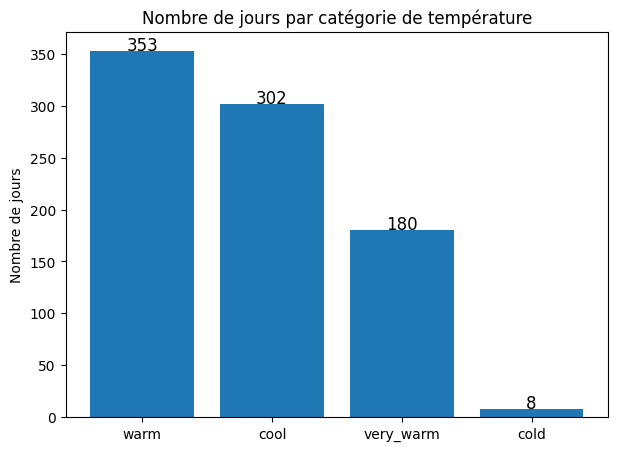

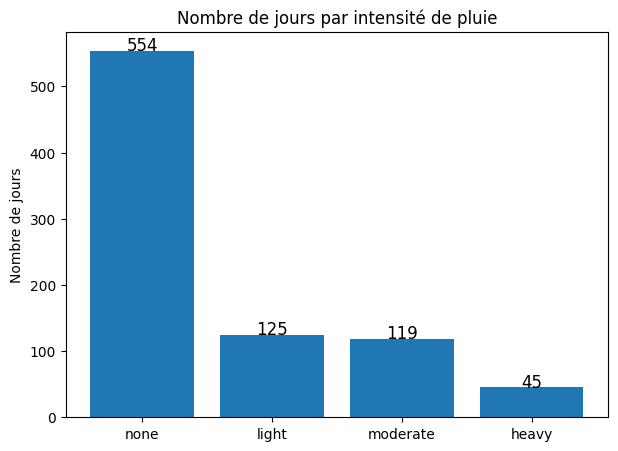

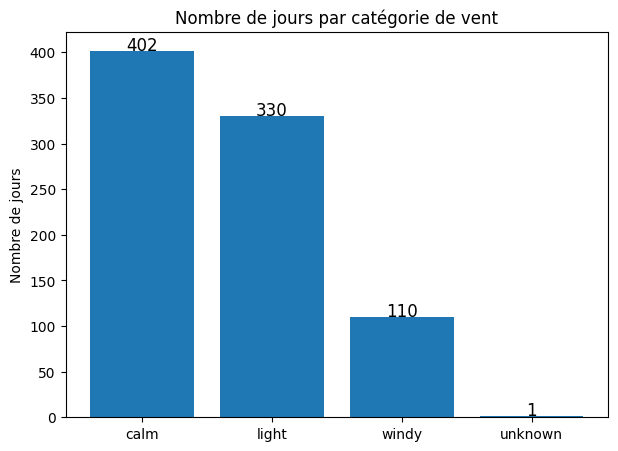

In [58]:

# Plot for temperature categories
plt.figure(figsize=(7,5))
temp_counts = meteo_jour["temp_category"].value_counts()

plt.bar(temp_counts.index, temp_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de température")

for i, v in enumerate(temp_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for rain categories
plt.figure(figsize=(7,5))
rain_counts = meteo_jour["rain_category"].value_counts()

plt.bar(rain_counts.index, rain_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par intensité de pluie")

for i, v in enumerate(rain_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()

# Plot for wind categories
plt.figure(figsize=(7,5))
wind_counts = meteo_jour["wind_category"].value_counts()

plt.bar(wind_counts.index, wind_counts.values)
plt.ylabel("Nombre de jours")
plt.title("Nombre de jours par catégorie de vent")

for i, v in enumerate(wind_counts.values):
    plt.text(i, v + 0.5, str(v), ha='center', fontsize=12)

plt.show()




Note : I don't know why there is an unkwon category 

In [32]:
# 1️⃣ Convertir en string
meteo_jour["AAAAMMJJ"] = meteo_jour["AAAAMMJJ"].astype(int).astype(str)

# 2️⃣ Transformer en datetime
meteo_jour["datetime_day"] = pd.to_datetime(meteo_jour["AAAAMMJJ"], format="%Y%m%d").dt.date

# Vérifier
print(meteo_jour)


     AAAAMMJJ  T_moy   RR  vent_kmh temp_category rain_category wind_category  \
0    20190101   6.90  0.0     13.32          cool          none         light   
1    20190102   5.45  0.0     21.96          cool          none         windy   
2    20190103   2.45  0.0     20.52          cool          none         windy   
3    20190104   2.75  0.0     18.00          cool          none         light   
4    20190105   2.75  0.0     19.08          cool          none         light   
..        ...    ...  ...       ...           ...           ...           ...   
838  20210418   9.25  0.0     15.48          cool          none         light   
839  20210419  10.25  0.0     10.44          warm          none         light   
840  20210420  11.15  0.2      7.20          warm         light          calm   
841  20210421  12.80  0.2      7.92          warm         light          calm   
842  20210422  13.85  0.0      9.00          warm          none          calm   

    datetime_day  
0     20

#### e) Create df_meteo : merge meteo_jour with data_bike 

Add the data of velov

In [40]:
def read_whole_pandas_df(path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = ['donnees/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv', 'donnees/VELO-LYON/Trajets VELOV 2020/VELOV_TRAJETS_2020_T2.csv']
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [41]:
BASE_PATH = r"data/"  #replace with base path to velo's data
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
LYON_CENTER = (45.764043, 4.835659)

In [42]:
df_lyon = read_whole_pandas_df(LYON_PATH, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=False)

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")

# Add here the size and type of the dataframe

print("The dataframe has size: {}".format(len(df_lyon)))
df_lyon.head()

Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2019\VELOV_TRAJETS_2019_T4.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T1.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T2.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T3.csv
Reading file data/VELO-LYON\Trajets VELOV 2020\VELOV_TRAJETS_2020_T4.csv
The dataframe has size: 15586007


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00


In [43]:
df_lyon['datetime_day'] = pd.to_datetime(df_lyon["date_return"]).dt.date

In [44]:
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_day,travel_time
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01,20.0
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01,8.0
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01,30.0
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01,20.0
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01,15.0


In [45]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

idstation,7024,10063,10021,8038,7045,6045,8056,8015,7057,7007,...,3035,6039,30002,12005,2027,3040,7017,3138,10049,10044
idstation,,,,,,,,,,,,,,,,,,,,,
7024,0.000000,3672.322221,4038.271301,2101.306115,1728.531155,2359.789599,1897.619990,2771.548411,1581.022503,1739.714329,...,1487.311727,2209.079367,8316.839400,7914.027093,1190.596433,1448.733485,1397.488839,1707.214746,4936.861621,5241.842046
10063,3672.322221,0.000000,367.937601,1918.014222,5276.485492,2393.483029,3362.975962,2193.760999,4699.773041,5159.729411,...,2185.076724,2763.907648,6395.079493,4458.602747,4860.315824,2233.220170,4667.580451,2109.599779,1478.056510,2520.604551
10021,4038.271301,367.937601,0.000000,2269.206815,5644.183932,2665.024201,3700.574285,2477.416757,5062.122623,5525.999425,...,2550.967781,3042.980467,6250.871362,4115.750370,5225.466883,2596.741636,5032.708705,2457.739820,1175.815415,2354.611591
8038,2101.306115,1918.014222,2269.206815,0.000000,3484.503141,2327.918947,1467.055847,883.373258,2817.475111,3322.282657,...,940.820395,2518.623358,7840.242909,6376.168575,3252.453650,1066.873708,2814.886550,1368.271058,3379.142600,4169.994273
7045,1728.531155,5276.485492,5644.183932,3484.503141,0.000000,4061.439765,2522.986998,3875.840707,919.283986,340.362043,...,3133.747731,3865.225819,9954.924357,9612.529985,932.679947,3123.005262,758.389211,3425.591997,6614.809720,6970.331063


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_day,travel_time,distance
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01,20.0,1137.895337
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01,8.0,1873.815972
2,6037,6037 - CITÉ INTERNATIONALE / INTERPOL,2019-01-01 00:02:00+01:00,10025.0,10025 - TOTEM,2019-01-01 00:32:00+01:00,2019-01-01,30.0,2777.866158
3,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01,20.0,3962.183210
4,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01,15.0,1352.710257


In [46]:
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]
df_lyon = df_lyon[df_lyon.travel_time<30]
df_lyon = df_lyon[df_lyon.travel_time>0]
df_lyon.sample(10)

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_day,travel_time,distance
10721710,10059,10059 - ANATOLE FRANCE / ZOLA,2020-06-04 06:41:00+02:00,10049.0,10049 - PRESSENSÉ,2020-06-04 06:46:00+02:00,2020-06-04,5.0,970.401375
4703152,3081,3081 - PART-DIEU / FRANCFORT,2019-07-23 18:02:00+02:00,7064.0,7064 - CROUS,2019-07-23 18:15:00+02:00,2019-07-23,13.0,2063.217682
10869092,7016,7016 - PLACE SAINT LOUIS,2020-06-11 08:13:00+02:00,7031.0,7031 - JAURÈS / GERLAND,2020-06-11 08:20:00+02:00,2020-06-11,7.0,1180.279774
9038148,7055,7055 - SERVANT / JABOULAY,2020-01-29 15:33:00+01:00,7006.0,7006 - GERLAND,2020-01-29 15:42:00+01:00,2020-01-29,9.0,2292.408445
9530204,10075,10075 - GABRIEL PÉRI,2020-02-19 10:43:00+01:00,10101.0,10101 - EINSTEIN / 11 NOVEMBRE 1918,2020-02-19 10:52:00+01:00,2020-02-19,9.0,1023.615780
6063185,2012,2012 - GAILLETON,2019-09-21 10:39:00+02:00,1032.0,1032 - PIZAY,2019-09-21 10:49:00+02:00,2019-09-21,10.0,1545.072455
9173782,3080,3080 - PART-DIEU / VILLETTE,2020-02-04 17:13:00+01:00,1031.0,1031 - PLACE DE LA PAIX,2020-02-04 17:28:00+01:00,2020-02-04,15.0,2489.118445
7855742,8010,8010 - PLACE MENDÈS FRANCE,2019-11-30 07:41:00+01:00,8052.0,8052 - CLINIQUE MONPLAISIR,2019-11-30 07:45:00+01:00,2019-11-30,4.0,783.113258
943604,3021,3021 - PLACE DE LA FERRANDIÈRE,2019-02-16 13:10:00+01:00,3080.0,3080 - PART-DIEU / VILLETTE,2019-02-16 13:15:00+01:00,2019-02-16,5.0,599.608238
53768,2026,2026 - RÉPUBLIQUE / PAUFIQUE,2019-01-04 19:18:00+01:00,3003.0,3003 - PART-DIEU / DERUELLE,2019-01-04 19:31:00+01:00,2019-01-04,13.0,1575.569004


ajoutez la vitesse pour le filtre 

In [47]:
df_meteo = df_lyon.merge(meteo_jour, on="datetime_day", how="left")
df_meteo

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_day,travel_time,distance,AAAAMMJJ,T_moy,RR,vent_kmh,temp_category,rain_category,wind_category
0,6005,6005 - PLACE EDGAR QUINET,2019-01-01 00:00:00+01:00,2024.0,2024 - RÉPUBLIQUE / MAUPIN,2019-01-01 00:20:00+01:00,2019-01-01,20.0,1137.895337,20190101,6.90,0.0,13.32,cool,none,light
1,10072,10072 - JACQUES BREL,2019-01-01 00:01:00+01:00,4012.0,4012 - PLACE ADRIEN GODIEN,2019-01-01 00:09:00+01:00,2019-01-01,8.0,1873.815972,20190101,6.90,0.0,13.32,cool,none,light
2,3012,3012 - PLACE DU CHÂTEAU,2019-01-01 00:06:00+01:00,7002.0,7002 - UNIVERSITÉS LYON III / LYON II,2019-01-01 00:26:00+01:00,2019-01-01,20.0,3962.183210,20190101,6.90,0.0,13.32,cool,none,light
3,1002,1002 - OPÉRA,2019-01-01 00:07:00+01:00,7056.0,7056 - PLACE RASPAIL,2019-01-01 00:22:00+01:00,2019-01-01,15.0,1352.710257,20190101,6.90,0.0,13.32,cool,none,light
4,7056,7056 - PLACE RASPAIL,2019-01-01 00:07:00+01:00,7039.0,7039 - GUILLOTIÈRE / MADELEINE,2019-01-01 00:11:00+01:00,2019-01-01,4.0,772.821424,20190101,6.90,0.0,13.32,cool,none,light
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14049925,3009,3009 - MUSEE AFRICAIN,2020-12-31 23:41:00+01:00,7036.0,7036 - GRYPHE / MONTESQUIEU,2020-12-31 23:45:00+01:00,2020-12-31,4.0,1114.496145,20201231,2.85,8.2,23.04,cool,moderate,windy
14049926,2035,2035 - CHILDEBERT / RIVIÈRE,2020-12-31 23:42:00+01:00,1003.0,1003 - PLACE SATHONAY,2020-12-31 23:52:00+01:00,2020-12-31,10.0,1132.489628,20201231,2.85,8.2,23.04,cool,moderate,windy
14049927,8035,8035 - SANS SOUCI,2020-12-31 23:43:00+01:00,1031.0,1031 - PLACE DE LA PAIX,2021-01-01 00:02:00+01:00,2021-01-01,19.0,3491.715445,20210101,3.10,0.0,15.84,cool,none,light
14049928,3103,3103 - PLACE DANTON,2020-12-31 23:48:00+01:00,10021.0,10021 - GRANDCLÉMENT,2020-12-31 23:58:00+01:00,2020-12-31,10.0,2574.757449,20201231,2.85,8.2,23.04,cool,moderate,windy


#### f) Multiple linear regressions 

In [48]:
def my_train_test_split(X, Y, rate = 0.8):
    split_idx = int(len(X) * rate)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def build_coeffs_df(model):
    df_coeff = pd.DataFrame({
        'Coefficient': model.coef_
    }, index = X.columns)
    df_coeff.sort_values(by='Coefficient', ascending=False, inplace=True) 
    df_coeff = df_coeff.T
    df_coeff['intercept'] = model.intercept_
    df_coeff = df_coeff.T

    return df_coeff

def build_validation_serie(y_test, y_pred):
    s_validation = pd.Series({
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })
    return s_validation

i) MLR with temperature 


In [49]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2 = df_meteo[['distance', 'travel_time', 'datetime_day', 'temp_category']].copy()
df_model2.sample(5)

,distance,travel_time,datetime_day,temp_category
8451011,2310.279048,11.0,2020-02-13,cool
284934,2481.935211,13.0,2019-01-18,cool
10352893,1056.396155,13.0,2020-07-05,very_warm
4108282,2331.000483,19.0,2019-07-18,very_warm
9526003,236.169100,2.0,2020-05-28,warm


In [50]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the category of temperature
df_model2_dummies = pd.get_dummies(df_model2, columns=['temp_category'], drop_first=True, dtype="int")
df_model2_dummies.sample(5)

,distance,travel_time,datetime_day,temp_category_cool,temp_category_very_warm,temp_category_warm
10840897,949.989449,6.0,2020-07-27,0,1,0
819264,717.306382,4.0,2019-02-15,1,0,0
24228,209.567113,17.0,2019-01-03,1,0,0
13299486,1034.627024,5.0,2020-11-06,0,0,1
11288710,1510.456980,7.0,2020-08-20,0,1,0


,Coefficient
temp_category_very_warm,0.597978
temp_category_warm,0.267855
distance,0.004856
temp_category_cool,-0.080530
intercept,2.581525


R²      0.622748
MSE    14.284118
MAE     2.690568
dtype: float64

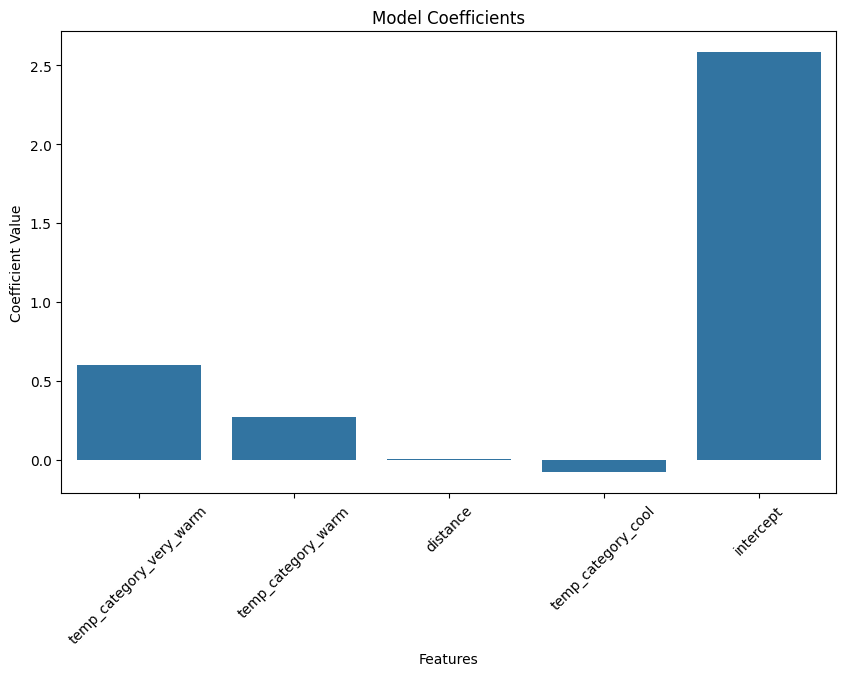

In [51]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which temperature category it is
## Splitting our data using my_train_test_split function
y = df_model2_dummies['travel_time']
X = df_model2_dummies.drop(columns=['datetime_day', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 2: model2_temp_category
model2_temp_category = LinearRegression()
model2_temp_category.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2_coeffs = build_coeffs_df(model2_temp_category)
display(df_model2_coeffs)
## Displaying the model 2's validation serie
y_pred_model2 = model2_temp_category.predict(X_test)
s_model2_validation = build_validation_serie(y_test, y_pred_model2)
display(s_model2_validation)
## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model2_coeffs.index, y='Coefficient', data=df_model2_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

ii) MLR temperature and rain

In [53]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2b = df_meteo[['distance', 'travel_time', 'datetime_day', 'temp_category', 'rain_category']].copy()
df_model2b.sample(5)

,distance,travel_time,datetime_day,temp_category,rain_category
1029137,4527.607221,21.0,2019-02-26,cool,none
7202375,1654.930895,9.0,2019-12-08,cool,light
10554181,1921.952757,13.0,2020-07-14,very_warm,none
10614532,2295.928761,19.0,2020-07-16,very_warm,none
4306709,954.088206,7.0,2019-07-30,very_warm,none


In [55]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model2b_dummies = pd.get_dummies(df_model2b, columns=['rain_category','temp_category'], drop_first=True, dtype="int")
df_model2b_dummies.sample(5)

,distance,travel_time,datetime_day,rain_category_light,rain_category_moderate,rain_category_none,temp_category_cool,temp_category_very_warm,temp_category_warm
10740585,1422.080312,14.0,2020-07-22,1,0,0,0,1,0
6227838,908.072628,9.0,2019-10-22,1,0,0,0,0,1
9444415,470.467063,21.0,2020-05-24,0,0,1,0,0,1
2731630,209.567113,5.0,2019-05-12,0,0,1,0,0,1
12443987,1507.689478,11.0,2020-09-29,1,0,0,0,0,1


,Coefficient
temp_category_very_warm,0.645999
temp_category_warm,0.356097
rain_category_none,0.278748
rain_category_light,0.059548
rain_category_moderate,0.034243
distance,0.004855
temp_category_cool,0.001096
intercept,2.304503


R²      0.622925
MSE    14.277421
MAE     2.687211
dtype: float64

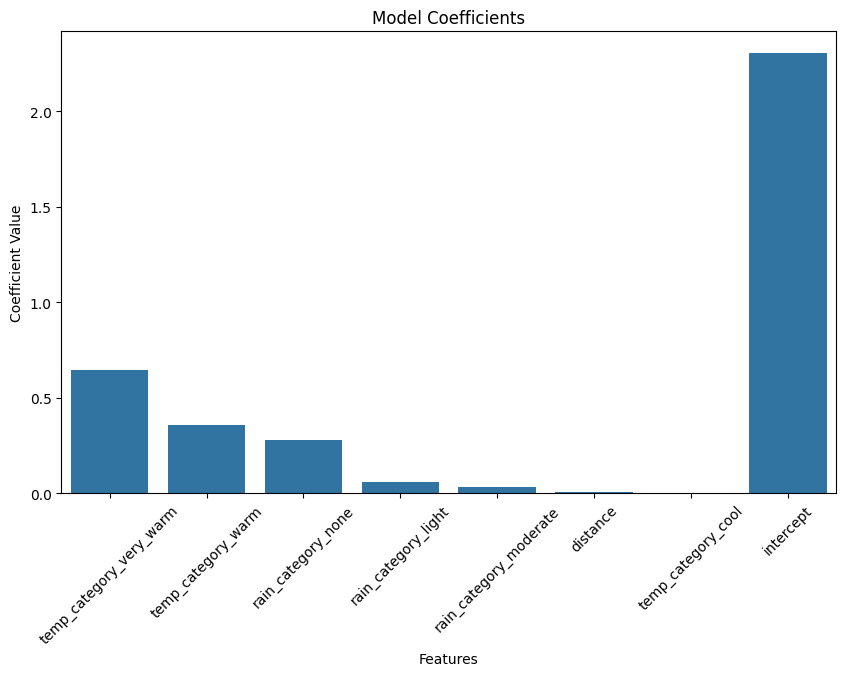

In [ ]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2b_dummies['travel_time']
X = df_model2b_dummies.drop(columns=['datetime_day', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model2b = LinearRegression()
model2b.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2b_coeffs = build_coeffs_df(model2b)
display(df_model2b_coeffs)

## Displaying the model 1's validation serie
y_pred_model2b = model2b.predict(X_test)
s_model2b_validation = build_validation_serie(y_test, y_pred_model2b)
display(s_model2b_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model2b_coeffs.index, y='Coefficient', data=df_model2b_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()



iii) MLR temperature, rain and wind - model_meteo

In [61]:
# Extracting a subset of our original dataframe with only the columns at use
df_model2c = df_meteo[['distance', 'travel_time', 'datetime_day', 'temp_category', 'rain_category', 'wind_category']].copy()
df_model2c.sample(5)

,distance,travel_time,datetime_day,temp_category,rain_category,wind_category
2739571,512.980369,25.0,2019-05-12,warm,none,windy
6405105,2594.977737,18.0,2019-10-30,warm,none,calm
12994100,358.955288,2.0,2020-10-19,cool,none,light
5297050,1105.219435,10.0,2019-09-17,very_warm,none,light
11474188,1643.031107,14.0,2020-08-29,warm,none,calm


In [66]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model2c_dummies = pd.get_dummies(df_model2c, columns=['rain_category','temp_category', 'wind_category'], drop_first=True, dtype="int")
df_model2c_dummies.sample(5)

,distance,travel_time,datetime_day,rain_category_light,rain_category_moderate,rain_category_none,temp_category_cool,temp_category_very_warm,temp_category_warm,wind_category_light,wind_category_unknown,wind_category_windy
1978898,1427.335898,8.0,2019-04-06,0,0,1,0,0,1,1,0,0
11389991,473.548679,7.0,2020-08-25,0,0,1,0,1,0,0,0,0
3693863,1096.831025,7.0,2019-06-27,0,0,1,0,1,0,0,0,0
12117047,1546.033893,10.0,2020-09-18,1,0,0,0,1,0,1,0,0
4035676,1486.286664,11.0,2019-07-15,0,0,1,0,1,0,0,0,1


,Coefficient
temp_category_very_warm,0.663706
temp_category_warm,0.378922
rain_category_none,0.249822
rain_category_light,0.043577
temp_category_cool,0.019839
rain_category_moderate,0.005499
distance,0.004854
wind_category_light,-0.003381
wind_category_unknown,-0.100584
wind_category_windy,-0.196807


R²      0.622832
MSE    14.280921
MAE     2.687562
dtype: float64

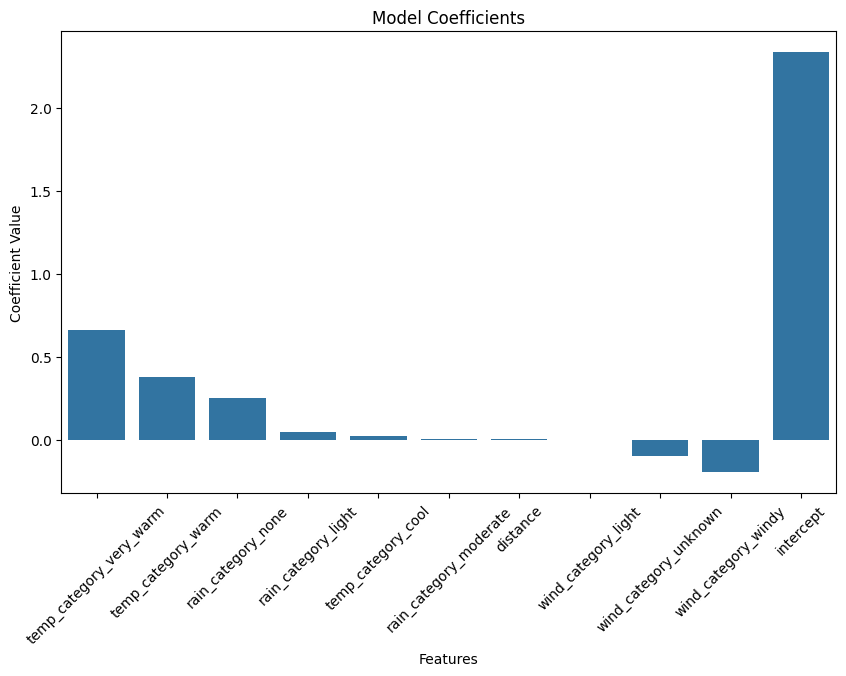

In [67]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model2c_dummies['travel_time']
X = df_model2c_dummies.drop(columns=['datetime_day', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model2c = LinearRegression()
model2c.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model2c_coeffs = build_coeffs_df(model2c)
display(df_model2c_coeffs)

## Displaying the model 1's validation serie
y_pred_model2c = model2c.predict(X_test)
s_model2c_validation = build_validation_serie(y_test, y_pred_model2c)
display(s_model2c_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model2c_coeffs.index, y='Coefficient', data=df_model2c_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()


#### iv) Create a model with interaction ? 

In [65]:
df_model2d = df_meteo[['distance', 'travel_time', 'datetime_day',
                     'temp_category', 'rain_category', 'wind_category']].copy()

df_model2d = pd.get_dummies(df_model2d,
                          columns=['temp_category', 'rain_category', 'wind_category'],
                          drop_first=True,  # pour éviter la colinéarité
                          dtype=int)

# --------------------------------------------------------
# 5. Création des interactions
# --------------------------------------------------------

# Interaction Distance × Température
temp_cols = [c for c in df_model2d.columns if c.startswith("temp_category_")]
for col in temp_cols:
    df_model2d[f"dist_x_{col}"] = df_model2d["distance"] * df_model2d[col]

# Interaction Distance × Pluie
rain_cols = [c for c in df_model2d.columns if c.startswith("rain_category_")]
for col in rain_cols:
    df_model2d[f"dist_x_{col}"] = df_model2d["distance"] * df_model2d[col]

# Interaction Distance × Vent
wind_cols = [c for c in df_model2d.columns if c.startswith("wind_category_")]
for col in wind_cols:
    df_model2d[f"dist_x_{col}"] = df_model2d["distance"] * df_model2d[col]

# --------------------------------------------------------
# 6. Préparation X / Y
# --------------------------------------------------------
y = df_model2d['travel_time']
X = df_model2d.drop(columns=['travel_time', 'datetime_day'])

# Split
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

# --------------------------------------------------------
# 7. Modèle linéaire
# --------------------------------------------------------
model_interactions = LinearRegression()
model_interactions.fit(X_train, y_train)

# --------------------------------------------------------
# 8. Coefficients
# --------------------------------------------------------
df_coeffs = build_coeffs_df(model_interactions)
display(df_coeffs)

# --------------------------------------------------------
# 9. Validation
# --------------------------------------------------------
y_pred = model_interactions.predict(X_test)
validation = build_validation_serie(y_test, y_pred)
display(validation)

,Coefficient
temp_category_very_warm,0.906257
temp_category_warm,0.510868
rain_category_none,0.180338
temp_category_cool,0.057052
wind_category_unknown,0.019394
distance,0.004884
dist_x_wind_category_windy,0.000080
dist_x_rain_category_none,0.000041
dist_x_rain_category_light,0.000032
dist_x_rain_category_moderate,0.000028


R²      0.622768
MSE    14.283347
MAE     2.688322
dtype: float64

In [ ]:
model_meteo=model2c
model=model_meteo
df= df_meteo

#### g) Test of model_meteo 